In [1]:
import os
import librosa
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import time

In [2]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.6 MB/s eta 0:00:00


In [3]:
# Dataset Directory
data_dir = "/kaggle/input/random-speech/archive/16000_pcm_speeches"
speakers = ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela',
            'FreeCodeCampF', 'Lt_General', 'MKBHD', 'MrWhoseTheBoss', 'Shashi_Tharoor', 'Swami_Vivekanand', 'bro_code']

# Background Noise Directory
background_noise_dir = os.path.join(data_dir, 'background_noise')

In [4]:
def extract_mfcc(audio_path, n_mfcc=13):
    try:
        y, sr = librosa.load(audio_path, res_type='kaiser_fast', sr=16000, duration=1)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Return the full 2D array instead of mean
        return mfccs
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def extract_mel_spectrogram(audio_path, n_mels=128):
    try:
        y, sr = librosa.load(audio_path, res_type='kaiser_fast', sr=16000, duration=1)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Return the full 2D array instead of mean
        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def extract_lpc(audio_path, order=12):
    try:
        y, sr = librosa.load(audio_path, res_type='kaiser_fast', sr=16000, duration=1)
        lpc_coeffs = librosa.lpc(y, order=order)
        if len(lpc_coeffs) < order + 1:
            lpc_coeffs = np.pad(lpc_coeffs, (0, order + 1 - len(lpc_coeffs)), 'constant')

        lpc_coeffs = lpc_coeffs[1:]  # Remove the first coefficient
        return lpc_coeffs.reshape(-1, 1)  # Reshape to 2D array for consistency
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [5]:
def augment_with_noise(features, background_noise_dir, noise_factor):
    noise_files = [f for f in os.listdir(background_noise_dir) if f.endswith('.wav')]
    if not noise_files:
        print("Warning: No background noise files found.")
        return features  # Return original features if no noise files

    try:
        noise_file = np.random.choice(noise_files)
        noise_path = os.path.join(background_noise_dir, noise_file)
        noise, sr = librosa.load(noise_path, sr=16000, duration=1)

        # Ensure features and noise are compatible for addition
        # For 2D features (MFCC, mel spectrogram), we'll augment each time frame
        if len(features.shape) == 2:
            # Reshape noise to be compatible with features
            noise_reshaped = np.zeros_like(features)
            for i in range(features.shape[0]):
                # Use samples of noise for each feature row (if enough samples)
                if i < len(noise):
                    noise_reshaped[i, :] = noise[i] if i < len(noise) else 0

            augmented_features = features + noise_factor * noise_reshaped
        # For 1D features (LPC)
        else:
            # Ensure noise is the same length as features
            if len(noise) < len(features):
                noise = np.pad(noise, (0, len(features) - len(noise)), mode='wrap')
            elif len(noise) > len(features):
                noise = noise[:len(features)]

            augmented_features = features + noise_factor * noise
        return augmented_features
    except Exception as e:
        print(f"Error Augmenting Data: {e}")
        return features  # Return original features on error

In [6]:
# Data Loading
def load_data(data_dir, speakers, feature_type='mfcc', use_background_noise=False, noise_factor=0.1):
    features = []
    labels = []

    for speaker_idx, speaker in enumerate(speakers):
        speaker_dir = os.path.join(data_dir, speaker)
        if not os.path.exists(speaker_dir):
            print(f"Warning: Directory {speaker_dir} does not exist.")
            continue

        audio_files = [f for f in os.listdir(speaker_dir) if f.endswith('.wav')]
        for audio_file in audio_files:
            audio_path = os.path.join(speaker_dir, audio_file)

            if feature_type == 'mfcc':
                extracted_features = extract_mfcc(audio_path)
            elif feature_type == 'mel':
                extracted_features = extract_mel_spectrogram(audio_path)
            elif feature_type == 'lpc':
                extracted_features = extract_lpc(audio_path)
            else:
                raise ValueError("Invalid feature_type. Choose 'mfcc', 'mel', or 'lpc'.")

            if extracted_features is not None:
                if use_background_noise and os.path.exists(background_noise_dir):
                    augmented_features = augment_with_noise(extracted_features, background_noise_dir, noise_factor)
                    features.append(augmented_features)
                    labels.append(speaker_idx)
                else:
                    features.append(extracted_features)
                    labels.append(speaker_idx)

    # Print some debug info about the features
    if features:
        print(f"Feature type: {feature_type}")
        print(f"Number of samples: {len(features)}")
        print(f"Sample feature shape: {features[0].shape}")
    else:
        print(f"No features extracted for {feature_type}")

    return features, labels

In [7]:
# CNN Model Training Function
def prepare_data_and_train_cnn(X_train, y_train, X_val, y_val, X_test, y_test, feature_type, speakers, label_encoder):
    num_classes = len(speakers)

    # Check if data is empty
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print("Error: One or more data sets are empty")
        return None, None, None, None

    # Print some debug info
    print(f"X_train length: {len(X_train)}")
    if len(X_train) > 0:
        print(f"X_train[0] shape: {X_train[0].shape}")

    # Handle LPC features differently than MFCC and Mel features
    if feature_type == 'lpc':
        # For LPC features, reshape for Dense layers
        X_train = np.array([x.flatten() for x in X_train])
        X_val = np.array([x.flatten() for x in X_val])
        X_test = np.array([x.flatten() for x in X_test])

        # Create simple dense model for LPC
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))
    else:
        # For MFCC and Mel features, we need to ensure uniform dimensions
        # Find the maximum length in each dimension
        max_freq_bins = max([x.shape[0] for x in X_train + X_val + X_test])
        max_time_frames = max([x.shape[1] for x in X_train + X_val + X_test])

        # Pad all features to have the same dimensions
        X_train_padded = np.zeros((len(X_train), max_freq_bins, max_time_frames))
        X_val_padded = np.zeros((len(X_val), max_freq_bins, max_time_frames))
        X_test_padded = np.zeros((len(X_test), max_freq_bins, max_time_frames))

        # Fill in the data
        for i, x in enumerate(X_train):
            X_train_padded[i, :x.shape[0], :x.shape[1]] = x
        for i, x in enumerate(X_val):
            X_val_padded[i, :x.shape[0], :x.shape[1]] = x
        for i, x in enumerate(X_test):
            X_test_padded[i, :x.shape[0], :x.shape[1]] = x

        # Update our variables
        X_train = X_train_padded
        X_val = X_val_padded
        X_test = X_test_padded

        # Reshape for Conv2D (samples, height, width, channels)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

        # CNN model for MFCC and Mel
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("CNN Model Summary:")
    model.summary()  # This will print the summary

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"CNN Test Loss: {loss:.4f}")
    print(f"CNN Test Accuracy: {accuracy:.4f}")

    return history, model, X_test, y_test

In [8]:
# LSTM Model Training Function
def prepare_data_and_train_lstm(X_train, y_train, X_val, y_val, X_test, y_test, feature_type, speakers, label_encoder, lstm_units=128, dropout_rate=0.5):
    """
    Prepares data for LSTM training, builds, and trains the LSTM model.
    """
    num_classes = len(speakers)

    # Check if data is empty
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print("Error: One or more data sets are empty")
        return None, None, None, None

    # For LPC features, reshape appropriately for LSTM
    if feature_type == 'lpc':
        # LPC features are already time series, just ensure correct shape
        X_train = np.array(X_train)
        X_val = np.array(X_val)
        X_test = np.array(X_test)
    else:
        # For MFCC and Mel, we need to transpose and pad the features
        # Here we treat the frequency bins as features and time frames as time steps
        max_time_frames = max([x.shape[1] for x in X_train + X_val + X_test])
        num_features = X_train[0].shape[0]  # Number of frequency bins

        # Pad all features to have the same time dimension
        X_train_padded = np.zeros((len(X_train), max_time_frames, num_features))
        X_val_padded = np.zeros((len(X_val), max_time_frames, num_features))
        X_test_padded = np.zeros((len(X_test), max_time_frames, num_features))

        # Fill in the data (transpose to make time the first dimension)
        for i, x in enumerate(X_train):
            X_train_padded[i, :x.shape[1], :] = x.T
        for i, x in enumerate(X_val):
            X_val_padded[i, :x.shape[1], :] = x.T
        for i, x in enumerate(X_test):
            X_test_padded[i, :x.shape[1], :] = x.T

        # Update our variables
        X_train = X_train_padded
        X_val = X_val_padded
        X_test = X_test_padded

    # Print the shape of prepared data
    print(f"X_train shape for LSTM: {X_train.shape}")
    print(f"X_val shape for LSTM: {X_val.shape}")
    print(f"X_test shape for LSTM: {X_test.shape}")

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("LSTM Model Summary:")
    model.summary()

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    if early_stopping.stopped_epoch > 0:
        print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
    else:
        print("Training completed without early stopping")

    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    return history, model, X_test, y_test

In [9]:
# Main Training Loop
def main():
    feature_types = ['mfcc', 'mel', 'lpc']
    model_types = ['cnn', 'lstm']
    results = {}
    use_background_noise = True  # Set to False if background_noise directory doesn't exist
    noise_factor = 0.1

    # Store resource utilization metrics
    resource_utilization = {}

    for model_type in model_types:
        results[model_type] = {}
        resource_utilization[model_type] = {}

        for feature_type in feature_types:
            print(f"\n{'='*50}")
            print(f"Training {model_type.upper()} with {feature_type.upper()} features...")
            print(f"{'='*50}")

            # Load and preprocess data
            features, labels = load_data(data_dir, speakers, feature_type=feature_type,
                                        use_background_noise=use_background_noise,
                                        noise_factor=noise_factor)

            if features and len(features) > 0:
                # Convert to numpy arrays
                labels = np.array(labels)

                # For scaling, only flatten LPC features, keep MFCC and Mel as 2D
                if feature_type == 'lpc':
                    features_flat = np.array([x.flatten() for x in features])
                    # Scale LPC features
                    scaler = StandardScaler()
                    features_flat = scaler.fit_transform(features_flat)
                    # Reshape back to original shape
                    features = [features_flat[i].reshape(features[i].shape) for i in range(len(features))]
                # For MFCC and Mel, we scale within each feature separately
                else:
                    # No flattening needed, keep as is
                    pass

                # Split data
                X_train, X_temp, y_train, y_temp = train_test_split(
                    features, labels, test_size=0.3, random_state=42, stratify=labels)
                X_val, X_test, y_val, y_test = train_test_split(
                    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

                # Encode labels
                label_encoder = LabelEncoder()
                label_encoder.fit(labels)
                y_train = label_encoder.transform(y_train)
                y_val = label_encoder.transform(y_val)
                y_test = label_encoder.transform(y_test)

                # Start timing
                start_time = time.time()

                # Train model
                if model_type == 'cnn':
                    history, model, X_test_processed, y_test_processed = prepare_data_and_train_cnn(
                        X_train, y_train, X_val, y_val, X_test, y_test, feature_type, speakers, label_encoder)
                elif model_type == 'lstm':
                    history, model, X_test_processed, y_test_processed = prepare_data_and_train_lstm(
                        X_train, y_train, X_val, y_val, X_test, y_test, feature_type, speakers, label_encoder)

                # End timing
                end_time = time.time()

                # Check if model training was successful
                if history is not None and model is not None:

                    # Calculate metrics
                    num_test_samples = len(X_test)
                    training_time = end_time - start_time
                    inference_time = training_time / num_test_samples * 1000  # in milliseconds

                    # Model size (we don't save the model now, so model_size will be 0, or we can skip this)
                    model_size = 0 # Model size is 0 as we are not saving the model
                    num_params = model.count_params() / 1e6  # in millions

                    # Store results and metrics
                    resource_utilization[model_type][feature_type] = {
                        'model_size': model_size,
                        'num_params': num_params,
                        'inference_time': inference_time,
                        'training_time': training_time
                    }

                    results[model_type][feature_type] = {
                        'history': history,
                        'model': model,
                        'X_test': X_test_processed,
                        'y_test': y_test_processed,
                        'label_encoder': label_encoder,
                    }

                    print(f"Completed training {model_type.upper()} with {feature_type.upper()} features")
                    print(f"Training time: {training_time:.2f} seconds")
                    print(f"Model size: {model_size:.2f} MB (Not saved)") # Indicate model is not saved
                    print(f"Number of parameters: {num_params:.2f} million")
                else:
                    print(f"Failed to train {model_type.upper()} with {feature_type.upper()} features")
            else:
                print(f"No data loaded for {feature_type}. Skipping training.")

    # Visualization: Accuracy Comparison Chart
    feature_names = ['MFCC', 'Mel Spectrogram', 'LPC']
    plt.figure(figsize=(12, 6))

    # Check if we have results to plot
    has_cnn_results = all(feature in results.get('cnn', {}) and 'history' in results['cnn'][feature]
                          for feature in ['mfcc', 'mel', 'lpc'])
    has_lstm_results = all(feature in results.get('lstm', {}) and 'history' in results['lstm'][feature]
                           for feature in ['mfcc', 'mel', 'lpc'])

    if has_cnn_results and has_lstm_results:
        cnn_accuracies = [results['cnn'][feature]['history'].history['val_accuracy'][-1]
                          for feature in ['mfcc', 'mel', 'lpc']]
        lstm_accuracies = [results['lstm'][feature]['history'].history['val_accuracy'][-1]
                           for feature in ['mfcc', 'mel', 'lpc']]

        x = np.arange(len(feature_names))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, cnn_accuracies, width, label='CNN', color='skyblue')
        rects2 = ax.bar(x + width/2, lstm_accuracies, width, label='LSTM', color='salmon')

        # Add labels, title, etc.
        ax.set_ylabel('Validation Accuracy (%)')
        ax.set_xlabel('Feature Extraction Method')
        ax.set_title('Accuracy Comparison between Feature Extraction Methods and Models')
        ax.set_xticks(x)
        ax.set_xticklabels(feature_names)
        ax.legend()

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        fig.tight_layout()
        plt.ylim(0, 1)
        plt.show()
    else:
        print("Not enough data to create accuracy comparison chart")

    # Visualization: Confusion Matrix for best model
    # Select best model based on validation accuracy
    best_model_type = None
    best_feature_type = None
    best_accuracy = -1

    for model_type in model_types:
        for feature_type in feature_types:
            if (feature_type in results.get(model_type, {}) and
                'history' in results[model_type][feature_type]):
                accuracy = results[model_type][feature_type]['history'].history['val_accuracy'][-1]
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model_type = model_type
                    best_feature_type = feature_type

    if best_model_type and best_feature_type:
        print(f"\nBest model: {best_model_type.upper()} with {best_feature_type.upper()} features")
        print(f"Validation accuracy: {best_accuracy:.4f}")

        model = results[best_model_type][best_feature_type]['model']
        X_test = results[best_model_type][best_feature_type]['X_test']
        y_test = results[best_model_type][best_feature_type]['y_test']
        label_encoder = results[best_model_type][best_feature_type]['label_encoder']

        y_pred_probabilities = model.predict(X_test)
        y_pred = np.argmax(y_pred_probabilities, axis=1)

        y_test_decoded = label_encoder.inverse_transform(y_test)
        y_pred_decoded = label_encoder.inverse_transform(y_pred)

        unique_labels = label_encoder.classes_
        conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=unique_labels)
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
                   xticklabels=unique_labels, yticklabels=unique_labels)

        plt.xticks(rotation=45, ha="right")
        plt.title(f"Confusion Matrix for Best Model ({best_model_type.upper()} with {best_feature_type.upper()})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
    else:
        print("No valid models found to generate the confusion matrix.")

    # Visualization: Resource Utilization Comparison
    model_types_used = [mt for mt in model_types if mt in resource_utilization]

    if model_types_used and all(ft in resource_utilization[model_types_used[0]] for ft in feature_types):
        # Extract metrics
        model_sizes = {}
        num_params = {}
        inference_times = {}

        for model_type in model_types_used:
            model_sizes[model_type] = [
                resource_utilization[model_type].get(feature, {}).get('model_size', 0)
                for feature in feature_types
            ]
            num_params[model_type] = [
                resource_utilization[model_type].get(feature, {}).get('num_params', 0)
                for feature in feature_types
            ]
            inference_times[model_type] = [
                resource_utilization[model_type].get(feature, {}).get('inference_time', 0)
                for feature in feature_types
            ]

        x = np.arange(len(feature_types))
        width = 0.2

        fig, axes = plt.subplots(3, 1, figsize=(12, 18))

        # Model Size Comparison
        axes[0].bar(x - width, model_sizes[model_types_used[0]], width=width,
                   label=f'{model_types_used[0].upper()}', color='skyblue')
        if len(model_types_used) > 1:
            axes[0].bar(x, model_sizes[model_types_used[1]], width=width,
                       label=f'{model_types_used[1].upper()}', color='salmon')

        axes[0].set_xticks(x)
        axes[0].set_xticklabels(feature_types)
        axes[0].set_ylabel('Model Size (MB)')
        axes[0].set_title('Model Size Comparison')
        axes[0].legend()

        # Number of Parameters Comparison
        axes[1].bar(x - width, num_params[model_types_used[0]], width=width,
                   label=f'{model_types_used[0].upper()}', color='skyblue')
        if len(model_types_used) > 1:
            axes[1].bar(x, num_params[model_types_used[1]], width=width,
                       label=f'{model_types_used[1].upper()}', color='salmon')

        axes[1].set_xticks(x)
        axes[1].set_xticklabels(feature_types)
        axes[1].set_ylabel('Number of Parameters (Millions)')
        axes[1].set_title('Number of Parameters Comparison')
        axes[1].legend()

        # Inference Time Comparison
        axes[2].bar(x - width, inference_times[model_types_used[0]], width=width,
                   label=f'{model_types_used[0].upper()}', color='skyblue')
        if len(model_types_used) > 1:
            axes[2].bar(x, inference_times[model_types_used[1]], width=width,
                       label=f'{model_types_used[1].upper()}', color='salmon')

        axes[2].set_xticks(x)
        axes[2].set_xticklabels(feature_types)
        axes[2].set_ylabel('Inference Time (ms)')
        axes[2].set_title('Inference Time Comparison')
        axes[2].legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to create resource utilization comparison charts")


Training CNN with MFCC features...
Feature type: mfcc
Number of samples: 18001
Sample feature shape: (13, 32)
X_train length: 12600
X_train[0] shape: (13, 32)
CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 11, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 15, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 13, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,644 (272.05 KB)

 Trainable params: 69,644 (272.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3529 - loss: 3.4098 - val_accuracy: 0.8204 - val_loss: 0.5502
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7679 - loss: 0.6979 - val_accuracy: 0.8848 - val_loss: 0.3535
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8454 - loss: 0.4710 - val_accuracy: 0.9307 - val_loss: 0.2279
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8903 - loss: 0.3421 - val_accuracy: 0.9359 - val_loss: 0.2066
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9097 - loss: 0.2948 - val_accuracy: 0.9337 - val_loss: 0.2179
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9203 - loss: 0.2518 - val_accuracy: 0.9489 - val_loss: 0.1878
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9257 - loss: 0.2370 - val_accuracy: 0.9293 - val_loss: 0.2245
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9189 - loss: 0.2489 - val_accuracy: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 30, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 6, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,495,052 (5.70 MB)

 Trainable params: 1,495,052 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4740 - loss: 3.8057 - val_accuracy: 0.9633 - val_loss: 0.1323
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9129 - loss: 0.2641 - val_accuracy: 0.9752 - val_loss: 0.0783
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9405 - loss: 0.1918 - val_accuracy: 0.9715 - val_loss: 0.0821
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9435 - loss: 0.1743 - val_accuracy: 0.9804 - val_loss: 0.0592
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9479 - loss: 0.1581 - val_accuracy: 0.9685 - val_loss: 0.0941
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9561 - loss: 0.1338 - val_accuracy: 0.9770 - val_loss: 0.0716
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9562 - loss: 0.1314 - val_accuracy: 0.9800 - val_loss: 0.0631
CNN Test Loss: 0.0651
CNN Test Accuracy: 0.9807
Completed training CNN with MEL features
Training time

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,700 (41.80 KB)

 Trainable params: 10,700 (41.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1464 - loss: 2.3909 - val_accuracy: 0.2267 - val_loss: 2.2391
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2092 - loss: 2.2381 - val_accuracy: 0.3159 - val_loss: 1.9996
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2872 - loss: 2.0341 - val_accuracy: 0.3519 - val_loss: 1.8566
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3076 - loss: 1.9357 - val_accuracy: 0.3526 - val_loss: 1.8303
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3179 - loss: 1.9159 - val_accuracy: 0.3630 - val_loss: 1.8142
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3270 - loss: 1.9053 - val_accuracy: 0.3507 - val_loss: 1.8043
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3350 - loss: 1.8936 - val_accuracy: 0.3689 - val_loss: 1.8082
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3336 - loss: 1.8903 - val_accuracy: 0

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,740 (319.30 KB)

 Trainable params: 81,740 (319.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2798 - loss: 2.1071 - val_accuracy: 0.8556 - val_loss: 0.6703
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6871 - loss: 0.9249 - val_accuracy: 0.9515 - val_loss: 0.2342
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8372 - loss: 0.5199 - val_accuracy: 0.9670 - val_loss: 0.1245
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8860 - loss: 0.3697 - val_accuracy: 0.9796 - val_loss: 0.0784
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9175 - loss: 0.2665 - val_accuracy: 0.9841 - val_loss: 0.0653
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9229 - loss: 0.2490 - val_accuracy: 0.9833 - val_loss: 0.0579
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9327 - loss: 0.2208 - val_accuracy: 0.9793 - val_loss: 0.0658
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9397 - loss: 0.1950 - val_accuracy: 0.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,620 (549.30 KB)

 Trainable params: 140,620 (549.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0820 - loss: 2.5782 - val_accuracy: 0.0837 - val_loss: 2.4844
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0884 - loss: 2.4872 - val_accuracy: 0.0837 - val_loss: 2.4840
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0805 - loss: 2.4868 - val_accuracy: 0.0837 - val_loss: 2.4840
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0832 - loss: 2.4839 - val_accuracy: 0.0837 - val_loss: 2.4840
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0884 - loss: 2.4849 - val_accuracy: 0.0837 - val_loss: 2.4840
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0796 - loss: 2.4847 - val_accuracy: 0.0837 - val_loss: 2.4840
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0803 - loss: 2.4853 - val_accuracy: 0.0837 - val_loss: 2.4840
Early stopping triggered at epoch 7
Test Loss: 2.4849
Test Accuracy: 0.0833
Completed training LSTM with

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,596 (295.30 KB)

 Trainable params: 75,596 (295.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1280 - loss: 2.4228 - val_accuracy: 0.1681 - val_loss: 2.2957
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1689 - loss: 2.3181 - val_accuracy: 0.2467 - val_loss: 2.1951
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2596 - loss: 2.0949 - val_accuracy: 0.3444 - val_loss: 1.8458
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3218 - loss: 1.9284 - val_accuracy: 0.3600 - val_loss: 1.8003
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3432 - loss: 1.8905 - val_accuracy: 0.3707 - val_loss: 1.7905
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3524 - loss: 1.8487 - val_accuracy: 0.3700 - val_loss: 1.7810
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3390 - loss: 1.8474 - val_accuracy: 0.3674 - val_loss: 1.7718
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3496 - loss: 1.8310 - val_accuracy: 0.

<Figure size 1200x600 with 0 Axes>

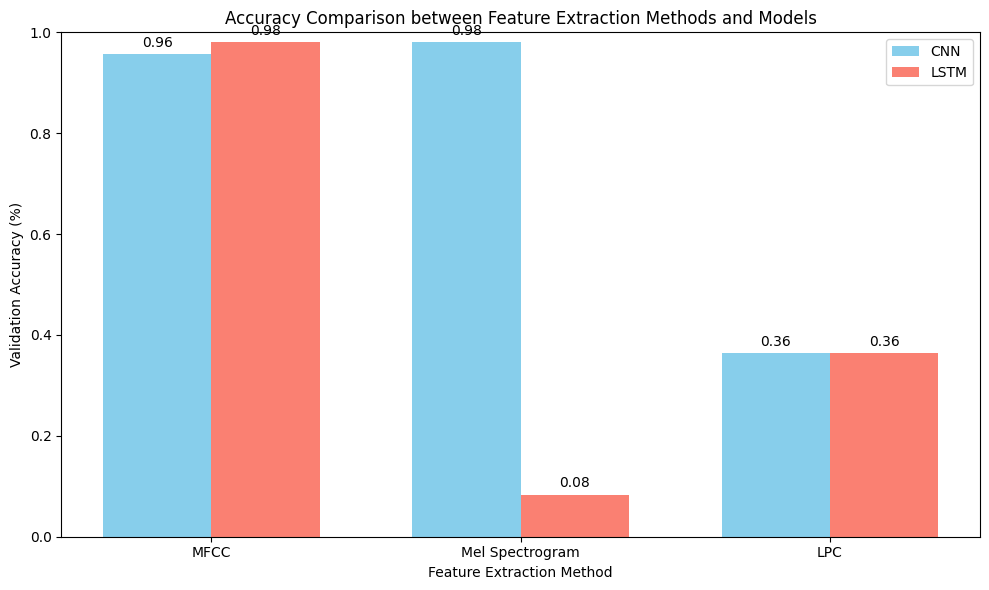


Best model: LSTM with MFCC features
Validation accuracy: 0.9804
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


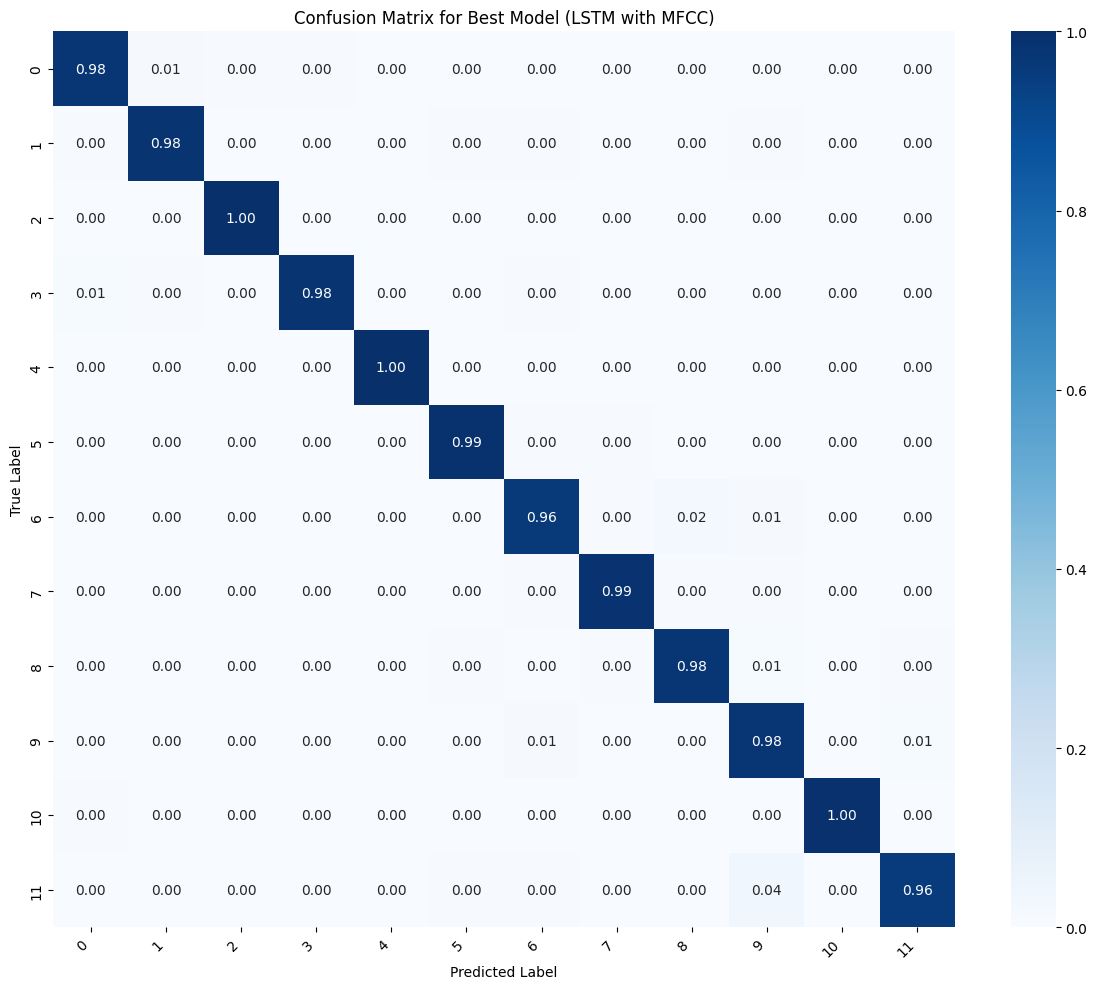

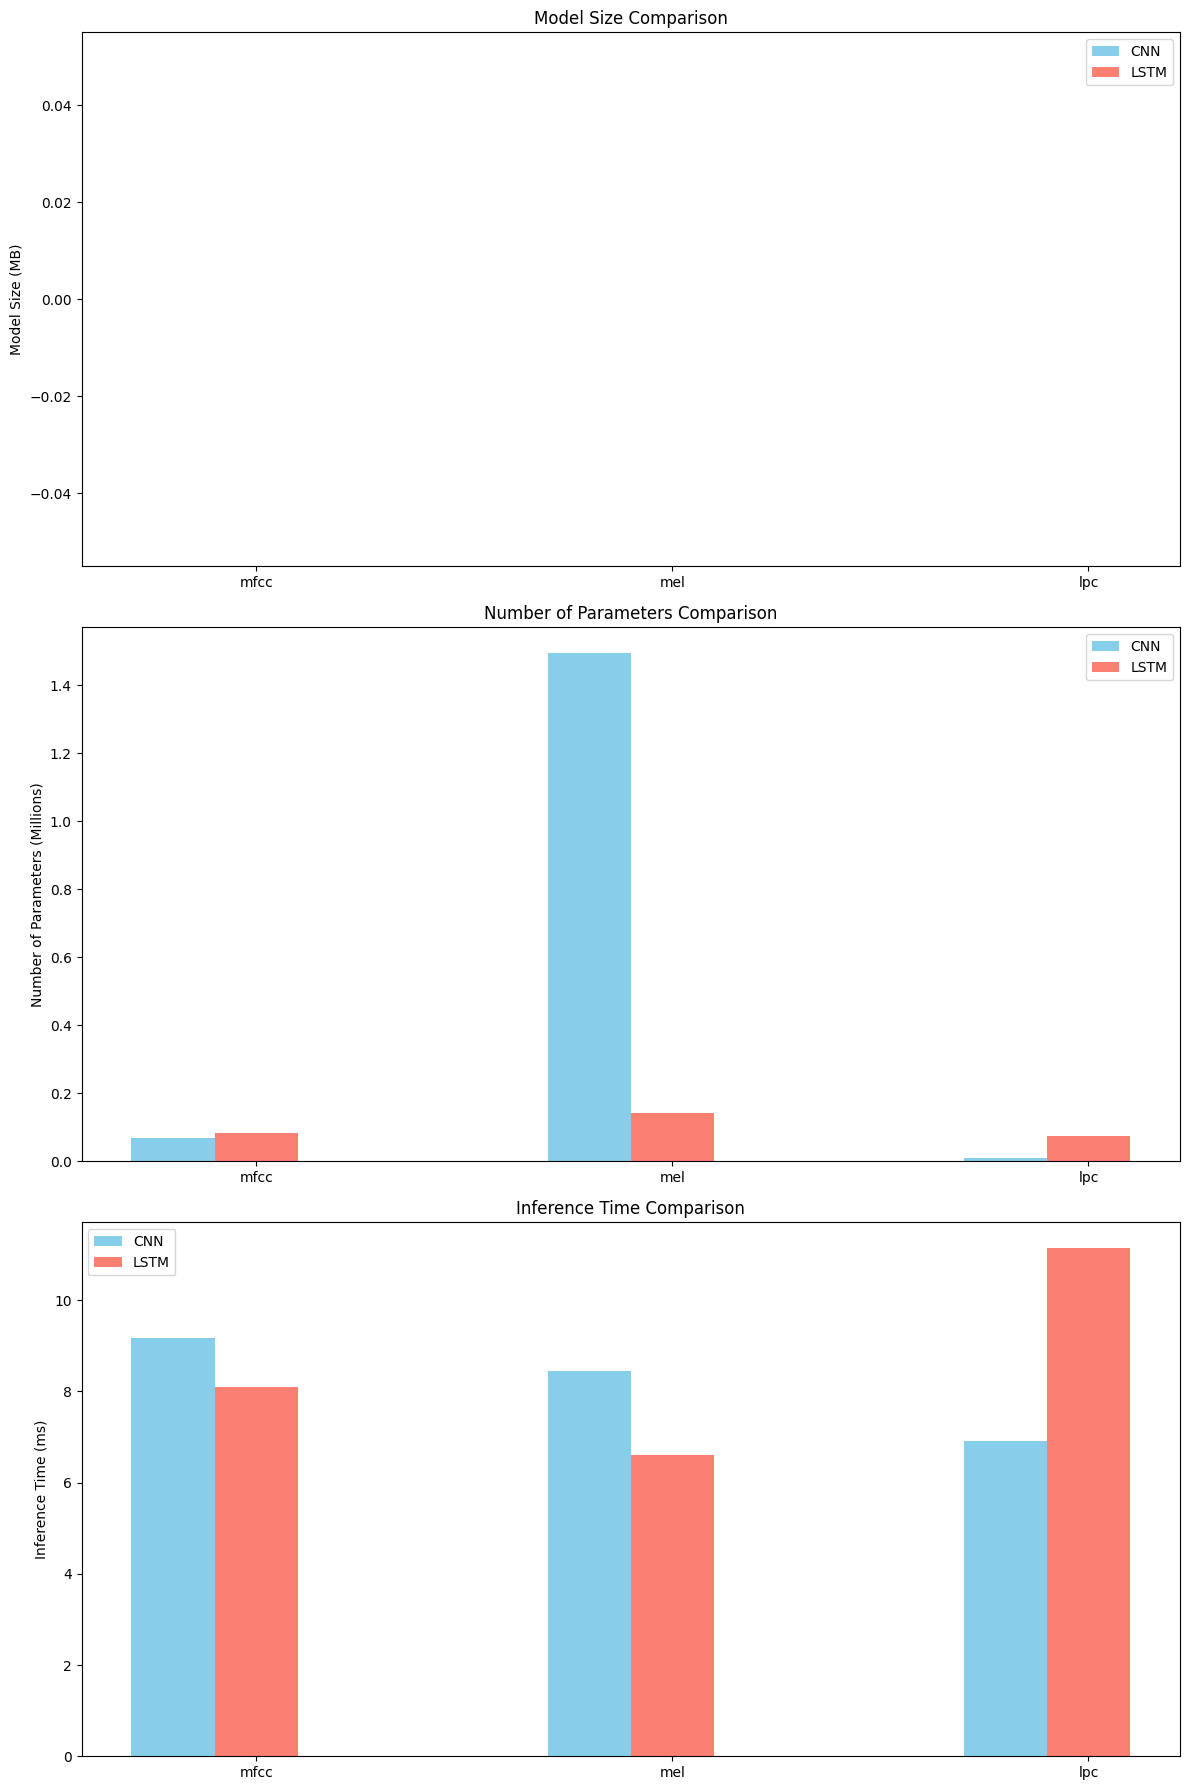

In [10]:
if __name__ == "__main__":
    main()